<a href="https://colab.research.google.com/github/anhnguyen17/JAPAN2020/blob/main/%5B3rd%5DFewshotlearningAttempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers==2.9.0

     |████████████████████████████████| 645kB 6.6MB/s 
     |████████████████████████████████| 5.6MB 9.8MB/s 
     |████████████████████████████████| 901kB 26.5MB/s 
     |████████████████████████████████| 1.2MB 34.2MB/s 


In [ ]:
import random
import pandas as pd
import numpy as np
import torch

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

set_seed(35)

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-base')

In [ ]:
#should try Adafactor optimizer as well
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in t5_model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
    {
        "params": [p for n, p in t5_model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-4, eps=1e-8)

In [ ]:
#dataset prep
tweet = [                      ("Bitcoin","Click this website to receive $10 in Bitcoin when you sign up!"),
                               ("pandemic","Click on this link for the ultimate guide on how to end the pandemic"),
                               ("Marvel","Pre-orders the newest Marvel movie available NOW with this link!"),
                               ("Psychology","This is the only developmental psychology book you will ever need . SAVE THIS LINK"),
                               ("Music", "Billboard's 2020 best music video is out now. Go to this link to view the chart."),
         
                               ("iPhone","Visit our website for a BIG DISCOUNT on your iPhone purchase!"),
                               ("workouts","Browse our website for some free energetic workouts"),
                               ("dating","Check out our page for 3 months free on the best dating site Tinder!!!!"),
                               ("tennis","Get free tennis lessons by clicking on this link!"),
                               ("Spanish", "Learn Spanish with natives. Log onto this link now"),
    
                               #("workouts","Browse our website for some free energetic workouts"),
                               #("dating","Check out our page for 3 months free on the best dating site Tinder!!!!"),
                               #("tennis","Get free tennis lessons by clicking on this link!"),
                               ("soccer", "World Cup 2022 is here! Check out the game schedule on this link RIGHT NOW...")
         
         
         ]

In [ ]:
t5_model.train()

epochs = 10
loss_data = []
for epoch in range(epochs):
  print ("epoch ",epoch)
  for input,output in tweet:
    input_kw = "tweet: "+input+ " </s>"
    output_tweet = output+" </s>"

    tokenized_input = tokenizer.encode_plus(input_kw,  max_length=100, pad_to_max_length=True,return_tensors="pt")
    tokenized_output = tokenizer.encode_plus(output_tweet, max_length=100, pad_to_max_length=True,return_tensors="pt")

    # the forward function that creates the correct decoder_input_ids
    output = t5_model(input_ids=tokenized_input["input_ids"], 
                      lm_labels=tokenized_output["input_ids"],
                      decoder_attention_mask=tokenized_output["attention_mask"],
                      attention_mask=tokenized_input["attention_mask"])
    loss = output[0]
    loss_num= loss.item()
    logits = output[1]
    #running_loss+=loss_num
    loss_data.append(loss_num)

    #calculate gradient
    loss.backward()

    #update the parameters
    optimizer.step()

    #clear gradients of all Var
    optimizer.zero_grad()


epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9


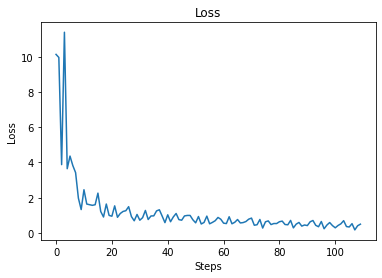

In [ ]:
import matplotlib.pyplot as plt
   
steps = [i for i in range(len(loss_data))]
  
plt.plot(steps, loss_data)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

In [ ]:
#Using beam search for decodeing
#Try model using Top K combine with Top p: https://huggingface.co/blog/how-to-generate

In [ ]:
test_kw = 'text: soccer </s>'
test_tokenized = tokenizer.encode_plus(test_kw, return_tensors="pt")

t5_model.eval()
beam_outputs = t5_model.generate(
    input_ids=test_tokenized["input_ids"],
    attention_mask=test_tokenized["attention_mask"],
    max_length=64,
    early_stopping=True,
    num_beams=10,
    num_return_sequences=3,
    no_repeat_ngram_size=2
)

for beam_output in beam_outputs:
    output = tokenizer.decode(beam_output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
    print(output)

Click on this link to find out how to get free soccer tickets.
Click on this link to find out how to get free soccer tickets!
Click on this link to get started!


In [ ]:
test_kw = 'text: soccer </s>'
test_tokenized = tokenizer.encode_plus(test_kw, return_tensors="pt")

test_input_ids  = test_tokenized["input_ids"]
test_attention_mask = test_tokenized["attention_mask"]

topNtopK_outputs = t5_model.generate(
    input_ids=test_tokenized["input_ids"],
    attention_mask=test_tokenized["attention_mask"],
    do_sample=True, 
    max_length=64, 
    top_k=50, 
    top_p=0.95, 
    num_return_sequences=3
)

#print("Output:\n" + 100 * '-')
for i, output in enumerate(topNtopK_outputs):
  print("{}: {}".format(i, tokenizer.decode(output, skip_special_tokens=True)))


0: SAVE THIS LINK NOW, for the ultimate in information & entertainment with a variety of options on our website.
1: Click here to access our homepage for more information on our site.
2: Find the most recent episode of this program on the link to sign up now.
